# Chapter 13: Convolutional Neural Networks

## Exercise 8.

Classifying large images using Inception v3. The code here is taken mostly from the author's solution since this exercise is mainly just learning how to use the API.

In [0]:
!pip install tensorflow-gpu

### a. Download some images of various animals. Load them in Python, for example using `matplotlib.image.mpimg.imread()` function or the `scipy.misc.imread()` function. Resize and/or crop them to 299$\times$299 pixels, and ensure that they have 3 channels (RGB). Ensure the images' values range from -1.0 to 1.0 to be compatible with Inception v3.

In [0]:
!ls img

ml_armadillo.jpg  ml_hippo.jpg	ml_owl.jpg	   ml_raccoon.jpg
ml_dog.jpg	  ml_lion.jpg	ml_polar_bear.jpg  ml_tiger.jpg


In [0]:
# Defining a function to transform the image for Inception v3.

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.transform import resize

height = 299
width = 299

def load_and_transform_img(filepath):
  img = mpimg.imread(filepath)
  h, w, _ = img.shape
  if w < h:
    dy = h - w
    img = img[dy//2:h-dy//2,:,:]
  else:
    dx = w - h
    img = img[:,dx//2:w-dx//2,:]
  img = resize(img, (height, width, 3))
  img = 2 * img - 1
  return img

### b. Download the latest pretrained Inception v3 model.

The model is available [on Github](https://github.com/tensorflow/models/tree/master/research/slim).

In [0]:
# Downloading the pre-trained model.

import sys
import os
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = \
    os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
  percent = count * block_size * 100 // total_size
  sys.stdout.write('\rDownload: {}%'.format(min(100, percent)))
  sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
  if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
    return
  os.makedirs(path, exist_ok=True)
  tgz_path = os.path.join(path, "inception_v3.tgz")
  urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
  inception_tgz = tarfile.open(tgz_path)
  inception_tgz.extractall(path=path)
  inception_tgz.close()
  os.remove(tgz_path)

In [6]:
fetch_pretrained_inception_v3()

Download: 100%

In [0]:
# Downloading the image class names

GITHUB_URL = 'https://raw.githubusercontent.com/ageron/handson-ml/'
IMAGENET_LABELS_PATH = 'master/datasets/inception/imagenet_class_names.txt'
IMAGE_LABELS_URL = os.path.join(GITHUB_URL, IMAGENET_LABELS_PATH)

def load_imagenet_labels(url=IMAGE_LABELS_URL, path=INCEPTION_PATH):
  labels_path = os.path.join(path, 'imagenet_class_names.txt')
  urllib.request.urlretrieve(url, labels_path, reporthook=download_progress)

In [0]:
load_imagenet_labels()

Download: 100%

In [0]:
# Defining a function to extract the class names from the file on Github.

import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
  path = os.path.join('datasets', 'inception', 'imagenet_class_names.txt')
  with open(path, encoding='utf-8') as f:
    content = f.read()
    return CLASS_NAME_REGEX.findall(content)

In [0]:
# Creating the labels for the classifier.

labels = ['background'] + load_class_names()
labels[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

### c. Create the Inception v3 model by calling the `inception_v3()` function. This must be done within an argument scope created by the `inception_v3_arg_scope()` function. Also, you must set `is_training=False` and `num_classes=1001`.

In [9]:
# Creating references to the Inception graph using the code in the book.

import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

graph = tf.Graph()

with graph.as_default():
  X = tf.placeholder(tf.float32, shape=(None, height, width, 3), name='X')
  with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001,
                                                is_training=False)
  predictions = end_points['Predictions']
  saver = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.


### d. Open a session and use the `Saver` to restore the pretrained model checkpoint.

In [0]:
with graph.as_default():
  with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


### e. Run the model to classify the images you prepared. Display the top 5 predictions for each image along with the estimated probability.

In [0]:
# Create a test set out of the images I uploaded.

import numpy as np

img_paths = os.listdir('img')
X_test = []
for path in img_paths:
  X_test.append(load_and_transform_img('img/' + path))
X_test = np.array(X_test, dtype=np.float32)

In [0]:
# Get the model's predictions.

with graph.as_default():
  with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 86.34%
brown bear, bruin, Ursus arctos: 1.05%
Samoyed, Samoyede: 0.41%
chow, chow chow: 0.30%
American black bear, black bear, Ursus americanus, Euarctos americanus: 0.14%


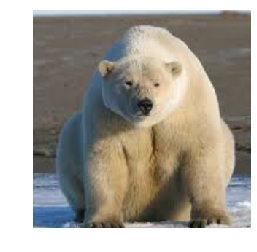

Labrador retriever: 59.12%
Chesapeake Bay retriever: 18.94%
golden retriever: 3.78%
Rhodesian ridgeback: 1.29%
bull mastiff: 0.73%


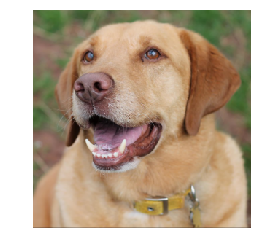

prairie chicken, prairie grouse, prairie fowl: 62.69%
ruffed grouse, partridge, Bonasa umbellus: 7.11%
great grey owl, great gray owl, Strix nebulosa: 5.58%
quail: 3.90%
partridge: 2.82%


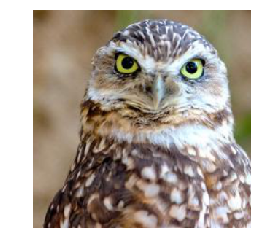

lion, king of beasts, Panthera leo: 95.65%
tiger, Panthera tigris: 0.09%
cheetah, chetah, Acinonyx jubatus: 0.08%
chow, chow chow: 0.08%
stopwatch, stop watch: 0.06%


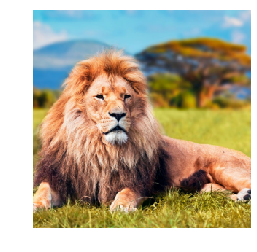

grey fox, gray fox, Urocyon cinereoargenteus: 58.36%
kit fox, Vulpes macrotis: 11.62%
red fox, Vulpes vulpes: 2.21%
mongoose: 0.92%
Arctic fox, white fox, Alopex lagopus: 0.86%


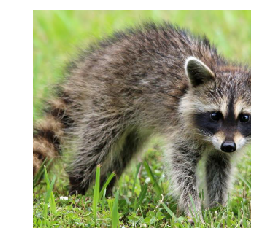

armadillo: 92.70%
water tower: 0.09%
spindle: 0.05%
airship, dirigible: 0.05%
warthog: 0.04%


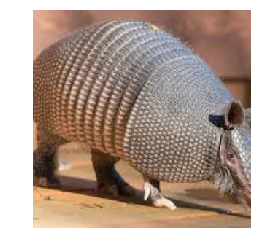

hippopotamus, hippo, river horse, Hippopotamus amphibius: 93.70%
lion, king of beasts, Panthera leo: 0.07%
tusker: 0.06%
warthog: 0.05%
stopwatch, stop watch: 0.04%


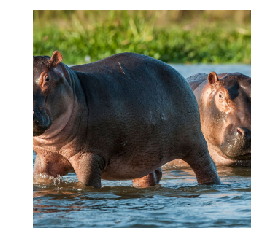

tiger, Panthera tigris: 90.64%
tiger cat: 5.69%
jaguar, panther, Panthera onca, Felis onca: 0.11%
leopard, Panthera pardus: 0.03%
tabby, tabby cat: 0.03%


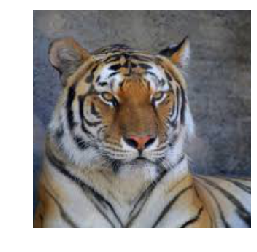

In [0]:
# Get the most likely labels and compare the output of the model
# to the actual picture.

for img, pred in zip(X_test, predictions_val):
  top_5 = np.argpartition(pred, -5)[-5:]
  top_5 = reversed(top_5[np.argsort(pred[top_5])])
  for i in top_5:
    print("{0}: {1:.2f}%".format(labels[i], 100 * pred[i]))
  plt.imshow((img + 1) / 2)
  plt.axis('off')
  plt.show()

## Exercise 9.

Transfer learning for large image classification.

### a. Create a training set containing at least 100 images per class.

For this exercise I will use the [flowers dataset](https://goo.gl/EgJVXZ).

In [0]:
# Fetching the dataset.

FLOWERS_DATA_URL = 'http://goo.gl/EgJVXZ'
FLOWERS_DATA_PATH = os.path.join('datasets', 'flowers')
FLOWERS_DOWNLOWD_PATH = os.path.join(FLOWERS_DATA_PATH, 'flower_photos')

def fetch_flowers_dataset(url=FLOWERS_DATA_URL, path=FLOWERS_DATA_PATH):
  if os.path.exists(FLOWERS_DOWNLOWD_PATH):
    return
  os.makedirs(path, exist_ok=True)
  tgz_path = os.path.join(path, 'flowers.tgz')
  urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
  places_tgz = tarfile.open(tgz_path)
  places_tgz.extractall(path=path)
  places_tgz.close()
  os.remove(tgz_path)

In [11]:
fetch_flowers_dataset()

Download: 100%

In [12]:
!ls datasets/flowers/flower_photos/

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


### b. Write a preprocessing step that will resize and crop the image to 299 $\times$ 299 with some randomness for data augmentation.

In [0]:
# A preprocessing function for augmenting the data
# using random scaling and translation.

import numpy as np

height = 299
width = 299

def get_augmented_images(img, n_images):
  images = [img]
  h, w, _ = img.shape
  for _ in range(n_images):
    rnd1 = np.random.uniform(0.0, 1.0)
    rnd2 = np.random.randint(0, 40)
    if rnd1 < 0.25:
      images.append(img[rnd2:,:,:])
    elif rnd1 < 0.5:
      images.append(img[:h-rnd2,:,:])
    elif rnd1 < 0.75:
      images.append(img[:,rnd2:,:])
    else:
      images.append(img[:,:w-rnd2,:])
  return images

def transform_and_augment_img(filepath, n_images=2):
  img = mpimg.imread(filepath)
  images = get_augmented_images(img, n_images)
  transformed_images = []
  for img in images:
    h, w, _ = img.shape
    if w < h:
      dy = h - w
      transformed_img = img[dy//2:h-dy//2,:,:]
    else:
      dx = w - h
      transformed_img = img[:,dx//2:w-dx//2,:]
    transformed_img = resize(transformed_img, (height, width, 3))
    transformed_images.append(2 * transformed_img - 1)
  return np.array(transformed_images)

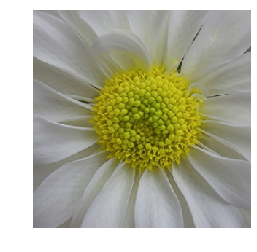

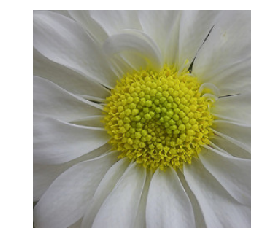

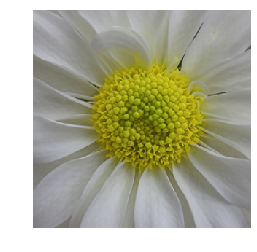

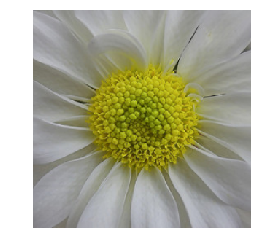

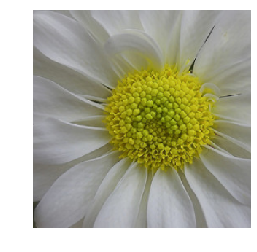

In [14]:
# Demoing the transformation and augmentation.

img_path = FLOWERS_DOWNLOWD_PATH + '/daisy/100080576_f52e8ee070_n.jpg'

for img in transform_and_augment_img(img_path, 4):
  plt.imshow((img + 1) / 2)
  plt.axis('off')
  plt.show()

### c. Using the pretrained Inception v3 model from the previous exercise, freeze all the layers up to the bottleneck layer (the layer before the output layer) and replace the output layer with the appropriate number of outputs for the new classification task.

In [0]:
# Setting up the same TensorFlow graph as before.

graph = tf.Graph()

with graph.as_default():
  X = tf.placeholder(tf.float32, shape=(None, height, width, 3), name='X')
  with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001,
                                                is_training=False)
  predictions = end_points['Predictions']
  saver = tf.train.Saver()

In [0]:
# Start a session that just writes the graph.

root_logdir = 'tf_logs'

with graph.as_default():
  with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    writer = tf.summary.FileWriter(root_logdir, sess.graph)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [0]:
# TensorBoard setup.

from datetime import datetime

now = datetime.utcnow().strftime('%Y%m%d%H%M%S')

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw(
  'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(root_logdir))
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [0]:
# Setting up the new model for transfer learning.

graph = tf.Graph()

n_outputs = 5
batch_size = 50

with graph.as_default():
  X = tf.placeholder(tf.float32, shape=(None, height, width, 3), name='X')
  y = tf.placeholder(tf.int32, shape=(None), name='y')
  training = tf.placeholder_with_default(False, shape=())

  with slim.arg_scope(inception.inception_v3_arg_scope()):
    _, end_points = inception.inception_v3(X, num_classes=1001,
                                           is_training=training)
  saver = tf.train.Saver()
  flattened = tf.squeeze(tf.squeeze(end_points['PreLogits'], axis=1), axis=1)
  logits = tf.layers.dense(flattened, n_outputs, name='flower_logits')
  flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope="flower_logits")
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,
                                                            labels=y)
  loss = tf.reduce_mean(xentropy)
  optimizer = tf.train.AdamOptimizer()
  training_op = optimizer.minimize(loss, var_list=flower_vars)

  correct = tf.nn.in_top_k(logits, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

  init = tf.global_variables_initializer()

### d. Split your dataset into a training set and test set. Train the model on the training set and evaluate it on the test set.

In [0]:
# Constructing the training and test set.

data = []
labels = []

for i, label in enumerate(
    ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']):
  label_dir_path = os.path.join(FLOWERS_DOWNLOWD_PATH, label)
  images = os.listdir(label_dir_path)
  for img in images[:400]:
    new_images = transform_and_augment_img(os.path.join(label_dir_path, img),
                                           n_images=0)
    data.extend(new_images)
    labels.extend([i] * len(new_images))

data = np.array(data)
labels = np.array(labels)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      random_state=42,
                                                      test_size=100)
del data, labels

In [0]:
# For mini-batch gradient descent.

def shuffle_batch(X, y, batch_size):
  rnd_idx = np.random.permutation(len(X))
  n_batches = len(X) // batch_size
  for batch_idx in np.array_split(rnd_idx, n_batches):
    X_batch, y_batch = X[batch_idx], y[batch_idx]
    yield X_batch, y_batch

In [29]:
# Training the new model with early stopping.

n_epochs = 10
n_batches = batch_size // (len(X_train) + len(X_valid) + len(X_test))
max_rounds_since_best_loss = 20
model_path = 'transfer_model.ckpt'

with graph.as_default():
  with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    for epoch in range(n_epochs):
      for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
      loss_val = loss.eval(feed_dict={X: X_valid, y: y_valid})
      acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
      print('Epoch:', epoch, ' Loss:', loss_val, ' Accuracy:', acc_val)
    acc_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print('Test set accuracy:', acc_val)

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch: 0  Loss: 0.7928944  Accuracy: 0.73
Epoch: 1  Loss: 0.58999234  Accuracy: 0.77
Epoch: 2  Loss: 0.55463225  Accuracy: 0.8
Epoch: 3  Loss: 0.48586658  Accuracy: 0.83
Epoch: 4  Loss: 0.46160084  Accuracy: 0.82
Epoch: 5  Loss: 0.4449337  Accuracy: 0.84
Epoch: 6  Loss: 0.4459329  Accuracy: 0.84
Epoch: 7  Loss: 0.44171554  Accuracy: 0.85
Epoch: 8  Loss: 0.41892308  Accuracy: 0.87
Epoch: 9  Loss: 0.40978637  Accuracy: 0.86
Test set accuracy: 0.91


In just 10 training epochs, the model is already able to achieve 91% accuracy on the test set! This is done even without data augmentation (which I had to omit during training due to RAM constraints).